In [ ]:
import cupy as cp
import numpy as np
from decorrelation.shp import ks_2sam
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
rslc = cp.load('./rslc.npy')
rmli = cp.abs(rslc)**2
sorted_rmli = cp.sort(rmli,axis=-1)

In [ ]:
ref_image = 15
sec_image = 16
diff = rslc[:,:,ref_image]*rslc[:,:,sec_image].conj()
ds_diff = cp.copy(diff)
ml_diff = cp.copy(diff)

In [ ]:
# here rslc is nlines*width*nimage

In [ ]:
rslc.shape

(2500, 1834, 17)

In [ ]:
rmli = cp.abs(rslc)**2
az_half_win = 10
r_half_win = 10

In [ ]:
patch_size = 50

In [ ]:
def patch_slice(data_shape,patch_size,boundary_size):
    max_az = data_shape[0]-boundary_size[0]-1
    min_az = boundary_size[0]
    max_r = data_shape[1]-boundary_size[1]-1 # notice right slice is open for python [min_az,max_az)
    min_r = boundary_size[1]
    
    n_az_patch = (max_az-min_az)//patch_size[0] # the finall small patch not included
    n_r_patch = (max_r-min_r)//patch_size[1]
    az_slices = [slice(min_az+i*patch_size[0],min_az+(i+1)*patch_size[0]) for i in range(n_az_patch)]
    az_slices.append(slice(min_az+n_az_patch*patch_size[0],max_az))
    r_slices = [slice(min_r+i*patch_size[1],min_r+(i+1)*patch_size[1]) for i in range(n_r_patch)]
    r_slices.append(slice(min_r+n_r_patch*patch_size[1],max_r))
    return az_slices, r_slices

In [ ]:
az_slices, r_slices = patch_slice(rslc.shape[:2],(patch_size,patch_size),(az_half_win,r_half_win))

In [ ]:
from itertools import product
for az_slice,r_slice in tqdm(product(az_slices,r_slices),total=len(az_slices)*len(r_slices)):
    az_index = np.arange(az_slice.start,az_slice.stop,dtype=int)
    r_index = np.arange(r_slice.start,r_slice.stop,dtype=int)
    az_win_index = np.arange(-az_half_win,az_half_win+1,dtype=int)
    r_win_index = np.arange(-r_half_win,r_half_win+1,dtype=int)

    # az_index, range_index, az_shift, range_shift
    a = np.meshgrid(az_index,r_index,az_win_index,r_win_index,indexing='ij')
    a = np.stack(a)

    # first 0 means return az_index, index of az_index, index of range_index,
    shp_table_shape = a[0,:,:,:,:].shape

    ref_shp_stack = sorted_rmli[a[0,:,:,:,:].reshape(-1),a[1,:,:,:,:].reshape(-1)]
    sec_shp_stack = sorted_rmli[(a[0,:,:,:,:]+a[2,:,:,:,:]).reshape(-1),(a[1,:,:,:,:]+a[3,:,:,:,:]).reshape(-1)]

    is_shp_stack = ks_2sam(ref_shp_stack,sec_shp_stack,0)
    is_shp_dense = is_shp_stack.reshape(shp_table_shape)

    shp_number_thres = 2
    num_shp = is_shp_dense.reshape(*is_shp_dense.shape[0:-2],-1).sum(axis=-1)
    num_shp.shape
    #TODO select base on number of num_shp

    rslc_0 = rslc[(a[0,:,:,:,:]+a[2,:,:,:,:]).reshape(-1),(a[1,:,:,:,:]+a[3,:,:,:,:]).reshape(-1),ref_image].reshape(*shp_table_shape[0:-2],-1)
    rslc_1 = rslc[(a[0,:,:,:,:]+a[2,:,:,:,:]).reshape(-1),(a[1,:,:,:,:]+a[3,:,:,:,:]).reshape(-1),sec_image].reshape(*shp_table_shape[0:-2],-1)
    rslc_1 = rslc_1*is_shp_dense.reshape(*is_shp_dense.shape[0:-2],-1) # set non-shp as zero
    ml_diff[az_slice,r_slice] = cp.sum(rslc_0*rslc_1.conj(),axis=-1)

100%|██████████| 1850/1850 [04:47<00:00,  6.44it/s]


In [ ]:
ref_image = 15
sec_image = 16

In [ ]:
# here rslc is nlines*width*nimage

In [ ]:
rslc.shape

(2500, 1834, 17)

In [ ]:
rmli = cp.abs(rslc)**2
az_half_win = 1
r_half_win = 1

In [ ]:
patch_size = 200

In [ ]:
def patch_slice(data_shape,patch_size,boundary_size):
    max_az = data_shape[0]-boundary_size[0]-1
    min_az = boundary_size[0]
    max_r = data_shape[1]-boundary_size[1]-1 # notice right slice is open for python [min_az,max_az)
    min_r = boundary_size[1]
    
    n_az_patch = (max_az-min_az)//patch_size[0] # the finall small patch not included
    n_r_patch = (max_r-min_r)//patch_size[1]
    az_slices = [slice(min_az+i*patch_size[0],min_az+(i+1)*patch_size[0]) for i in range(n_az_patch)]
    az_slices.append(slice(min_az+n_az_patch*patch_size[0],max_az))
    r_slices = [slice(min_r+i*patch_size[1],min_r+(i+1)*patch_size[1]) for i in range(n_r_patch)]
    r_slices.append(slice(min_r+n_r_patch*patch_size[1],max_r))
    return az_slices, r_slices

In [ ]:
az_slices, r_slices = patch_slice(rslc.shape[:2],(patch_size,patch_size),(az_half_win,r_half_win))

In [ ]:
from itertools import product
for az_slice,r_slice in tqdm(product(az_slices,r_slices),total=len(az_slices)*len(r_slices)):
    az_index = np.arange(az_slice.start,az_slice.stop,dtype=int)
    r_index = np.arange(r_slice.start,r_slice.stop,dtype=int)
    az_win_index = np.arange(-az_half_win,az_half_win+1,dtype=int)
    r_win_index = np.arange(-r_half_win,r_half_win+1,dtype=int)

    # az_index, range_index, az_shift, range_shift
    a = np.meshgrid(az_index,r_index,az_win_index,r_win_index,indexing='ij')
    a = np.stack(a)

    # first 0 means return az_index, index of az_index, index of range_index,
    shp_table_shape = a[0,:,:,:,:].shape
    a[0,:,:,:,:].reshape(-1)

    ref_shp_stack = sorted_rmli[a[0,:,:,:,:].reshape(-1),a[1,:,:,:,:].reshape(-1)]
    sec_shp_stack = sorted_rmli[(a[0,:,:,:,:]+a[2,:,:,:,:]).reshape(-1),(a[1,:,:,:,:]+a[3,:,:,:,:]).reshape(-1)]

    is_shp_stack = ks_2sam(ref_shp_stack,sec_shp_stack,0.5)
    is_shp_dense = is_shp_stack.reshape(shp_table_shape)

    shp_number_thres = 2
    num_shp = is_shp_dense.reshape(*is_shp_dense.shape[0:-2],-1).sum(axis=-1)
    num_shp.shape
    #TODO select base on number of num_shp

    rslc_0 = rslc[(a[0,:,:,:,:]+a[2,:,:,:,:]).reshape(-1),(a[1,:,:,:,:]+a[3,:,:,:,:]).reshape(-1),ref_image].reshape(*shp_table_shape[0:-2],-1)
    rslc_1 = rslc[(a[0,:,:,:,:]+a[2,:,:,:,:]).reshape(-1),(a[1,:,:,:,:]+a[3,:,:,:,:]).reshape(-1),sec_image].reshape(*shp_table_shape[0:-2],-1)
    rslc_1 = rslc_1*is_shp_dense.reshape(*is_shp_dense.shape[0:-2],-1) # set non-shp as zero
    ds_diff[az_slice,r_slice] = cp.sum(rslc_0*rslc_1.conj(),axis=-1)

100%|██████████| 1850/1850 [04:35<00:00,  6.71it/s]


In [ ]:
plot_bg = rmli[:,:,0]
plot_bg = cp.asnumpy(plot_bg)
alpha = bg_alpha(plot_bg)

<matplotlib.colorbar.Colorbar>

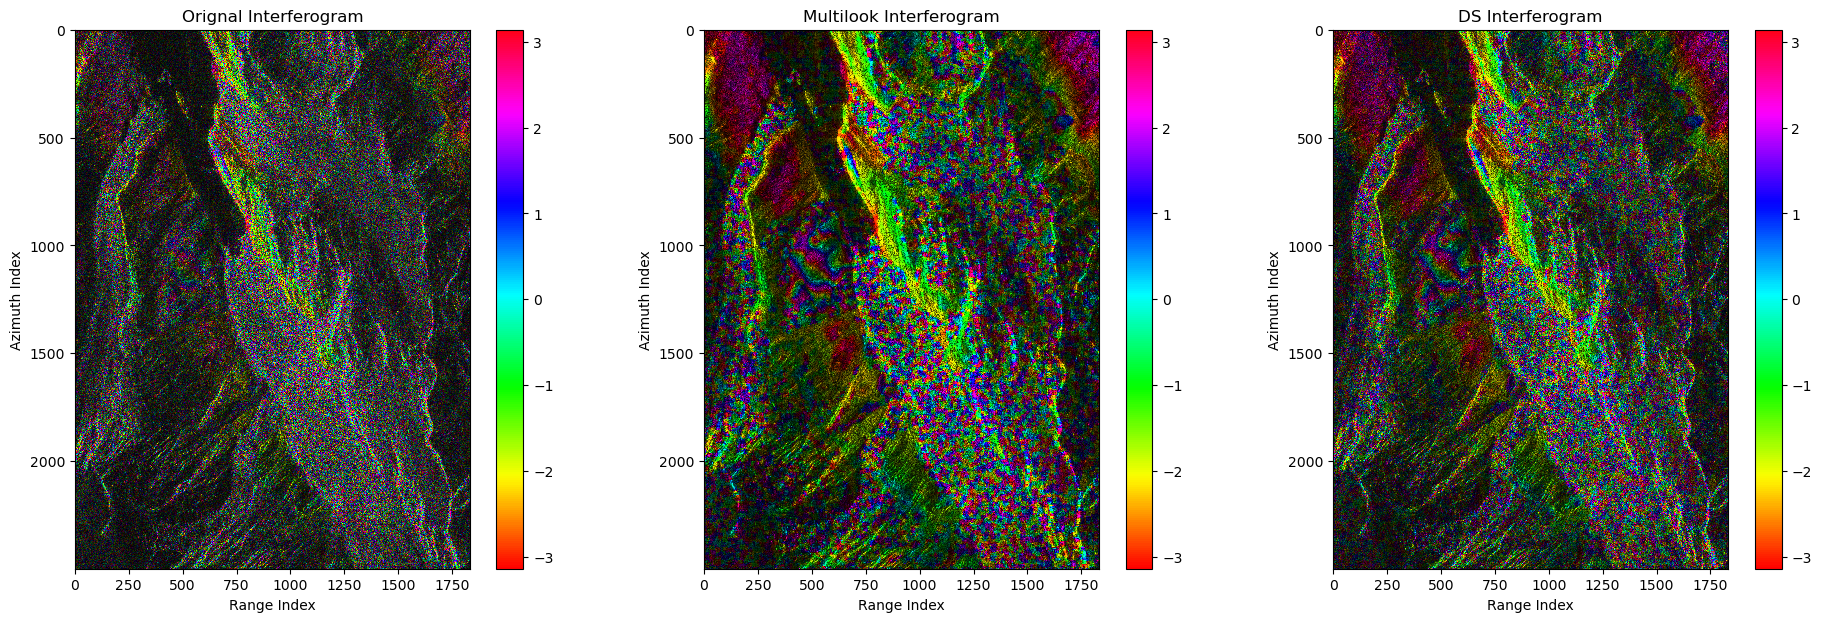

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(23,7))
xlabel = 'Range Index'
ylabel = 'Azimuth Index'
pcm0 = axes[0].imshow(cp.asnumpy(cp.angle(diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
pcm1 = axes[1].imshow(cp.asnumpy(cp.angle(ml_diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
pcm2 = axes[2].imshow(cp.asnumpy(cp.angle(ds_diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
# the real image showed is alpha*rgb + (1-alpha)*facecolor
for ax in axes:
    ax.set(facecolor = "black")
axes[0].set(title='Orignal Interferogram',xlabel=xlabel,ylabel=ylabel)
axes[1].set(title='Multilook Interferogram',xlabel=xlabel,ylabel=ylabel)
axes[2].set(title='DS Interferogram',xlabel=xlabel,ylabel=ylabel)
fig.colorbar(pcm0,ax=axes[0])
fig.colorbar(pcm1,ax=axes[1])
fig.colorbar(pcm1,ax=axes[2])

In [ ]:
def bg_alpha(pwr):
    _pwr = np.power(pwr,0.35)
    cv = _pwr.mean()*2.5
    v = (_pwr.clip(0., cv))/cv
    return v

<matplotlib.colorbar.Colorbar>

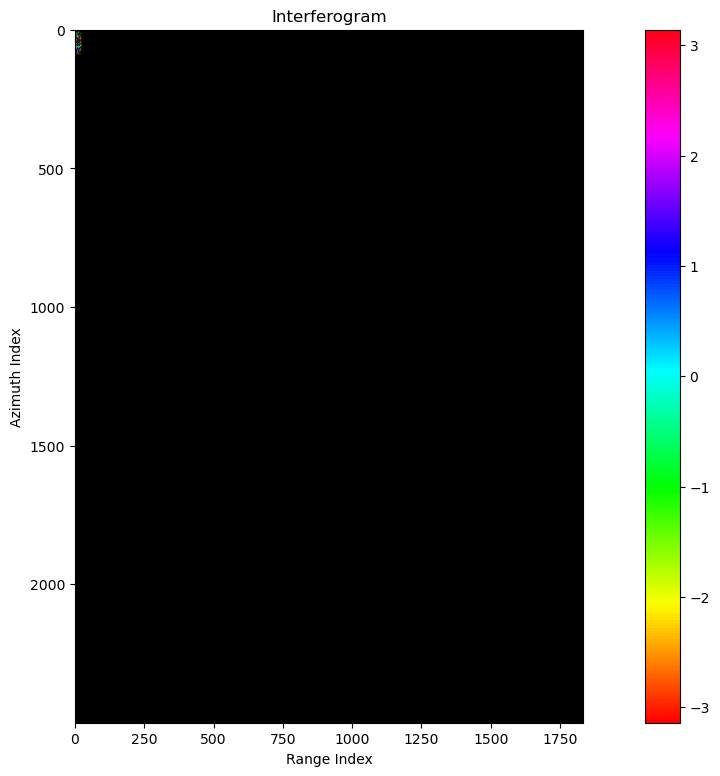

In [ ]:
plot_bg = rmli[a[0,:,:,0,0].reshape(-1),a[1,:,:,0,0].reshape(-1),0].reshape(*shp_table_shape[0:-2])
plot_bg = cp.asnumpy(plot_bg)
plot_data = cp.asnumpy(cp.angle(diff))

#extent = (np.min(r_index), np.max(r_index), np.max(az_index), np.min(az_index))

alpha = bg_alpha(plot_bg)

fig,ax = plt.subplots(1,1,figsize=(16,9))
xlabel = 'Range Index'
ylabel = 'Azimuth Index'
pcm0 = ax.imshow(plot_data,alpha=alpha,interpolation='nearest',cmap='hsv')
# the real image showed is alpha*rgb + (1-alpha)*facecolor
ax.set(facecolor = "black")
ax.set(title='Interferogram',xlabel=xlabel,ylabel=ylabel)
fig.colorbar(pcm0,ax=ax)